In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Bubble detection

The goal is to detect bubbles in the image. The bubbles are a little darker than the background and have a circle-like shape. They vary in sizes.

In [97]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

from bubbles.helpers import scale_wrt_vertical_gradient

In [3]:
def remove_axes_ticks(*axes):
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

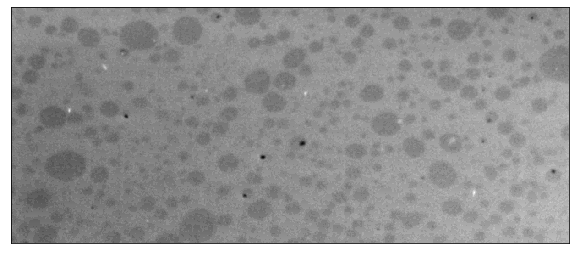

In [4]:
path = '../data/NextToWeldline-filtered.view0198.bmp'
img = cv2.imread(path, 0)    # 0 --> grayscale

# Removes the dark vertical gradient
img = scale_wrt_vertical_gradient(img)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, cmap='gray')
remove_axes_ticks(ax)

# Gaussian filtering

Apply gaussian filter to remove the noise in the background.

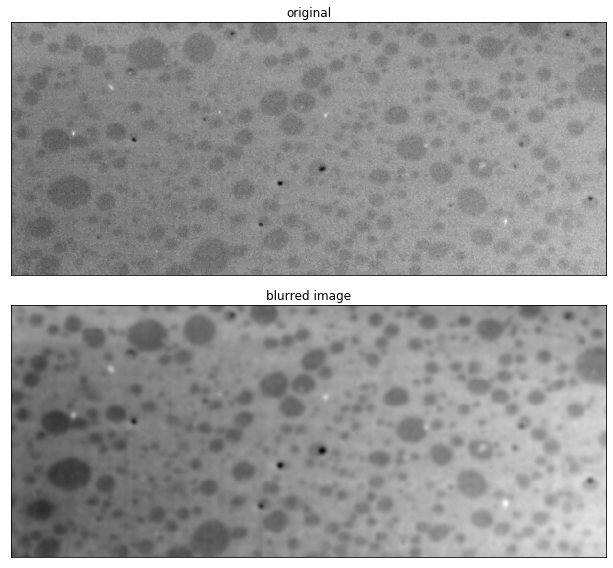

In [22]:
kernel_size = 21
img_smoothed = cv2.GaussianBlur(
    img,
    (kernel_size, kernel_size),
    sigmaX=0     # with 0 automatic computed (see docs) 
)

fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))
ax_upper.imshow(img, cmap='gray')
ax_upper.set_title('original')

ax_lower.imshow(img_smoothed, cmap='gray')
ax_lower.set_title('blurred image')

remove_axes_ticks(ax_upper, ax_lower)
fig.tight_layout()

# Canny edge

Apply edge detections to find the contours

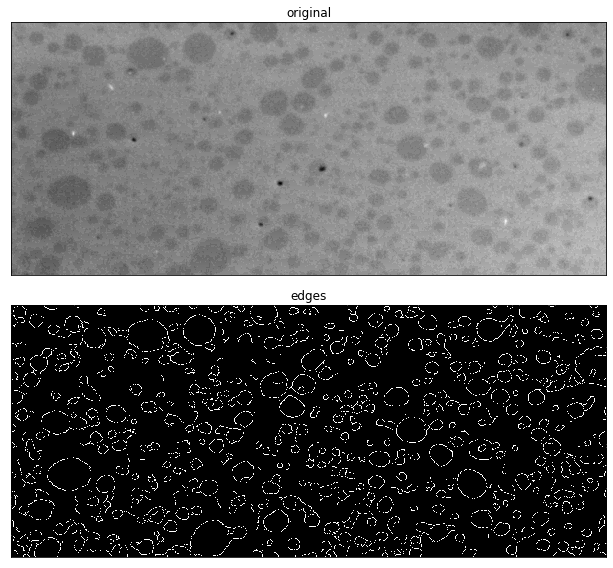

In [23]:
edges = cv2.Canny(
    img_smoothed, 
    threshold1=1000,     # thresholds used to determine edges
    threshold2=2000,     # (see docs)
    apertureSize=7,
    L2gradient=True
)

fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))

ax_upper.imshow(img, cmap='gray')
ax_upper.set_title('original')

ax_lower.imshow(edges, cmap='gray')
ax_lower.set_title('edges')

remove_axes_ticks(ax_upper, ax_lower)
fig.tight_layout()

# Find contours

Find the contours, useing the edges. Get stats on the contours with: https://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html

In [94]:
contours, hierarchy = cv2.findContours(
    edges, 
    cv2.RETR_TREE, 
    cv2.CHAIN_APPROX_SIMPLE
)

# contours = [cnt for cnt in contours if cv2.isContourConvex(cnt)]    # too strict
contours = [cnt for cnt in contours if len(cnt) > 10]

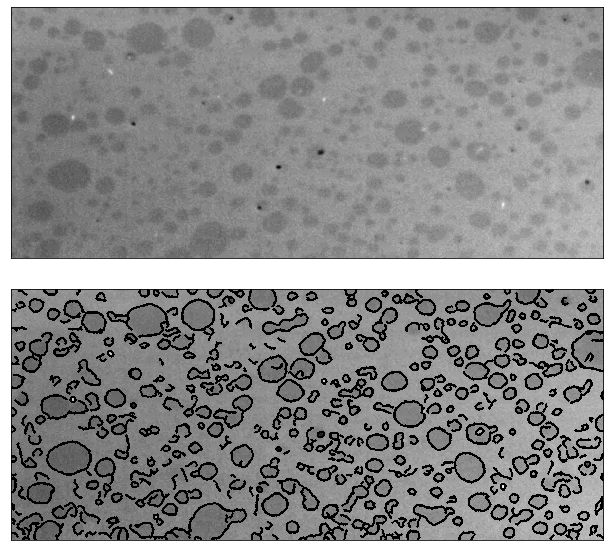

In [95]:
img_w_countours = cv2.drawContours(
    img.copy(), 
    contours, 
    -1,            # draw all contours
    color=0,             
    thickness=3
)

fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))

ax_upper.imshow(img, cmap='gray')
ax_lower.imshow(img_w_countours, cmap='gray')
fig.tight_layout()
remove_axes_ticks(ax_upper, ax_lower)

---

# Misc.

Everything below is me trying different things.

## Contour features

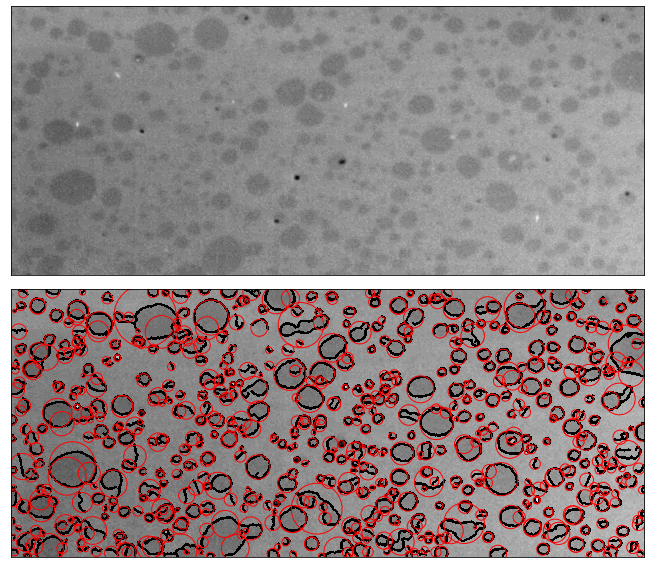

In [120]:
fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))

for cnt in contours:
    (x, y ), radius = cv2.minEnclosingCircle(cnt)
    ax_lower.add_artist(plt.Circle((x, y),  radius, color='r', fill=False))

ax_upper.imshow(img, cmap='gray')
ax_lower.imshow(img_w_countours, cmap='gray')
remove_axes_ticks(ax_lower, ax_upper)
fig.tight_layout()

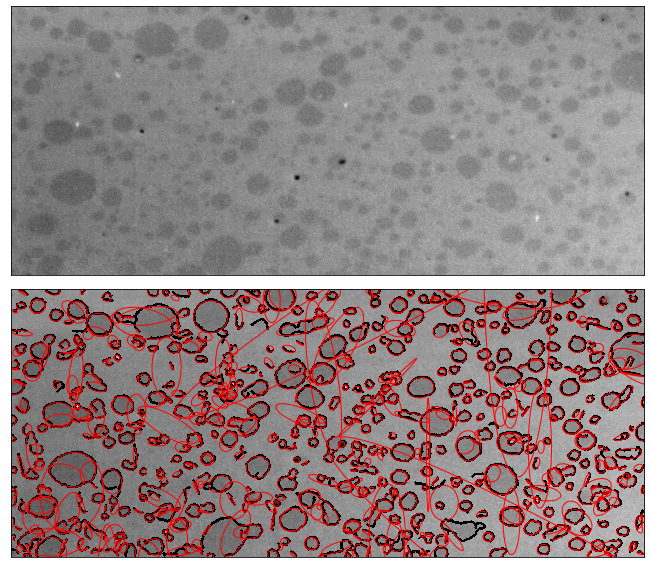

In [121]:
fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))

for cnt in contours:
    [xy, (width, height), angle] = cv2.fitEllipse(cnt)
    ax_lower.add_artist(matplotlib.patches.Ellipse(xy, width, height, angle, color='r', fill=False))

ax_upper.imshow(img, cmap='gray')
ax_lower.imshow(img_w_countours, cmap='gray')
remove_axes_ticks(ax_lower, ax_upper)
fig.tight_layout()

# Connect components

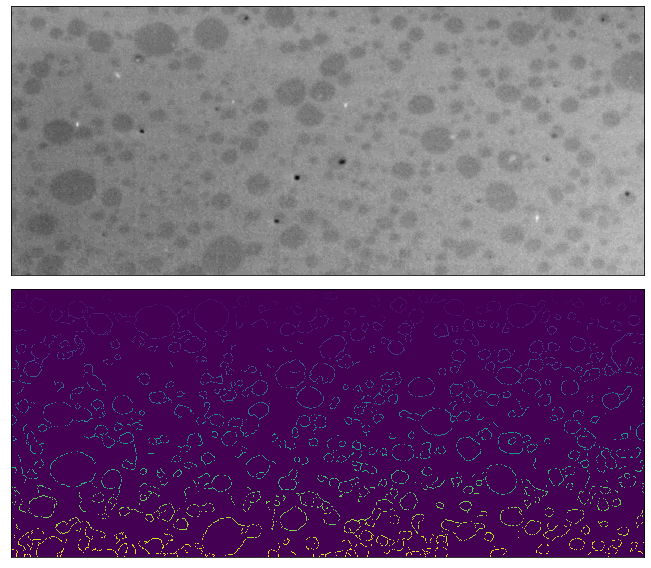

In [122]:
retval, labels = cv2.connectedComponents(
    edges, 
    connectivity=8, 
    ltype=cv2.CV_32S
)

fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))
ax_upper.imshow(img, cmap='gray')
ax_lower.imshow(labels)
remove_axes_ticks(ax_upper, ax_lower)
plt.tight_layout()

# Hough circles

Trying to find the circles. Does not work well. I think perfect circles are too restrictive.

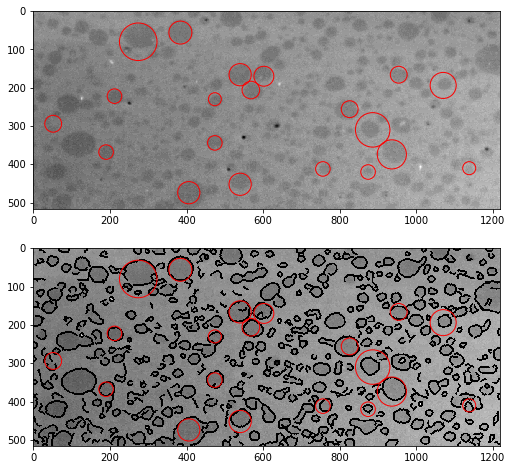

In [123]:
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(
    img_w_countours,
    cv2.HOUGH_GRADIENT,
    1,
    20,
    param1=50,
    param2=40,
    minRadius=0,
    maxRadius=50,
)

fig, (ax_upper, ax_lower) = plt.subplots(2, figsize=(10, 8))

circles = np.uint16(np.around(circles))

for circle in circles[0, :]:
    for ax in ax_upper, ax_lower:
        ax.add_artist(plt.Circle((circle[0], circle[1]),  circle[2], color='r', fill=False))

ax_upper.imshow(img, cmap='gray')
ax_lower.imshow(img_w_countours, cmap='gray')